<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Linear_systems_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals
- Be able to describe what makes a preconditioner good and bad
- Use package implementations to accelarate solving sparse linear systems.
- Recognize the *big picture* of how preconditioners are important in HPC

Examples for this lecture are drawn from [here](https://tbetcke.github.io/hpc_lecture_notes/intro.html)



#Preconditioners


The basic strategy of preconditioning is to modify the original linear system to one that *behaves better*:

- Direct solvers typically don't need *user specified* preconditioning since they are already robust and/or the preconditioner can be integrated. E.g.: Row swapping via the permutation matrix before conducting Gaussian Elimination / LU decomposition to achieve diagonal dominance which is cheap and easy to implement.

- Iterative solvers benefit substantially from preconditioners to achieve efficient convergence and control roundoff errors. Many (if not all) sparse matrix iterative solvers expect preconditioners and are applied *efficiently* during execution. Unfortuantely, **there is no general preconditioning technique that always works well** :-(

Certain preconditioners are effective on a particular type of physics, but even then the nature of the boundaries can torpedo convergence.

Preconditioners are an active field of research and key to solving large linear systems ($n=10^{6+})$. They are also critical to using distributed computing (HPC).

There are a variety of preconditioners, the mathematics of which we won't explore here. Rather, lets explore what to look for in a preconditioner, and how to use them.

Consider the linear system,
$Ax=b$
we want to multiply the equation by a matrix $P^{-1}$ to make the system easier to solve. As long as $P^{-1}$ isn't singular, the answer won't be changed.

### Left preconditioning

The most traditional and common preconditioner is:

$P^{-1} A x = P^{-1} b$











### Right preconditioning

A varient that is better for some cases

$A P^{-1} y = b$

with,

$P x = y $

### Two sided preconditioning

The combination of left and right:

$Q A P^{-1} y = Q b$

again with,

$P x = y$

this method may be needed to preserve symmetry of $A$ (which we have seen is very useful!). The problem is that in general the product of two symmetric matricies is not symmetric! If we say that $Q^T=P^{-1}$, then $QAP^{-1}$ is symmetric.

Recall that the inverse of a sparse matrix is typically dense, and therefore we don't usually want to store $P^{-1}$ explicitly. It is better to store $P$ and the method by which we would apply $P^{-1}$ to a vector. This is similar to solving a system by LU decomposition, $A=LU$. We don't calculate $A^{-1}$ explicitly, we keep $L$ and $U$ and solve systems sequentially.

### Qualities

The best preconditioner is $P = A$, which makes the system trivial. Failing this, we aim for $P^{-1} \approx A^{-1}$ *in some sense*. This can be quantified by the *condition number* of the preconditioned matrix, which we aim to make $=1$.

Preconditioner quality is based on:
- speed of computation and application of $P^{-1}$
- memory requirements of storing $P^{-1}$ (if it is stored)
- degree of *fill-in* (sparsity compared to $A$)
- parallelizability

Since calculation, storage, and application of $P^{-1}$ is an additional computational expense, the benefit must be *worth it*. Often this translates to the total speed of solution (preconditioning and iteration) but it may also extend to the stability of the computation.

E.g.: In time-dependent nonlinear PDEs, we will be solving linear systems thousands of times. A solver that takes twice as long every time but always converges may be better than one that solves fast but sometimes doesn't converge (which may spoil any progress you've made!).

# Examples

Let's discuss some common preconditioners and see their effect **on a particular system**.

## Jacobi

The Jacobi preconditioner (otherwise called diagonal scaling) is simply the main diagonal of $A$. The inverse is trivially the inverse of the diagonal elements, which means we can store $P^{-1}$ efficiently.


Example: Solve the discrete Poisson equation on the unit square,

$-\Delta u = 1$ on $\Omega=[0,1]^2$

with

$u=0$ on $\partial \Omega$

In [18]:
import numpy as np
from scipy.sparse import coo_matrix

def discretise_poisson(N, Q):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""

    nelements = 5 * N**2 - 16 * N + 16

    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)

    f = np.empty(N * N, dtype=np.float64)

    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1

            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i

                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = Q

                count += 5

    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

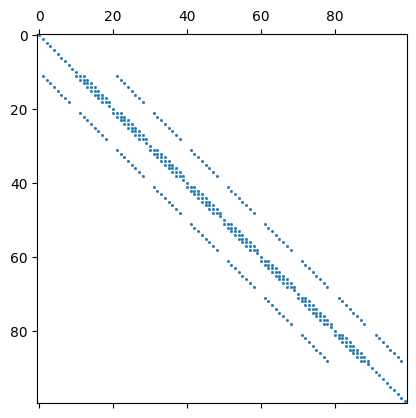

In [19]:
N = 10  # Mesh size
A, f = discretise_poisson(N, 1)

import matplotlib.pyplot as plt

plt.spy(A, markersize=1)
plt.show()

Implement a Jacobi preconditioner

Unconditioned condition number : 1115.4433890393989
Preconditioned condition number : 32.30864938962053
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.46944695e-18
 -1.38777878e-17 -1.38777878e-17 -2.77555756e-17 -2.77555756e-17
 -1.04083409e-17 -1.38777878e-17 -1.73472348e-18  0.00000000e+00
  0.00000000e+00 -1.73472348e-17 -3.46944695e-17 -3.46944695e-17
 -4.16333634e-17 -4.16333634e-17 -2.77555756e-17 -3.46944695e-17
 -1.04083409e-17  0.00000000e+00  0.00000000e+00 -1.38777878e-17
 -3.46944695e-17 -5.55111512e-17 -5.55111512e-17 -5.55111512e-17
 -4.85722573e-17 -3.46944695e-17 -1.04083409e-17  0.00000000e+00
  0.00000000e+00 -2.77555756e-17 -4.16333634e-17 -5.55111512e-17
 -5.55111512e-17 -5.55111512e-17 -5.55111512e-17 -4.16333634e-17
 -2.77555756e-17  0.00000000e+00  0.00000000e+00 -2.77555756e-17
 -4.16333634e-17 -5.55111512e-17 -5.55111512e-17 -4

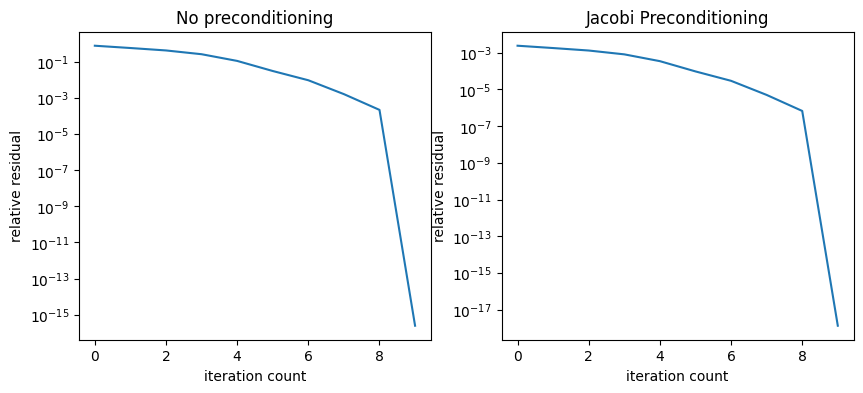

In [20]:
from scipy.sparse import diags#, LinearOperator
from scipy.sparse.linalg import gmres
from numpy.linalg import cond



Pinv_jacobi = diags(1/A.diagonal(), offsets = 0,format='csr')

print('Unconditioned condition number :', np.linalg.cond(A.todense()))
print('Preconditioned condition number :', np.linalg.cond(Pinv_jacobi@A.todense()))


residuals1 = []
callback1 = lambda res: residuals1.append(res)
residuals2 = []
callback2 = lambda res: residuals2.append(res)

#Solve the system using GMRES with the Jacobi preconditioner
x_uncond, _ = gmres(A, f, callback=callback1, callback_type='pr_norm')


x_cond, _ = gmres(A, f, M = Pinv_jacobi, callback=callback2, callback_type='pr_norm')

print(x_cond-x_uncond)


fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.semilogy(residuals1)
ax1.set_title('No preconditioning')
ax1.set_xlabel('iteration count')
ax1.set_ylabel('relative residual')

ax2 = fig.add_subplot(122)
ax2.semilogy(residuals2)
ax2.set_title('Jacobi Preconditioning')
ax2.set_xlabel('iteration count')
ax2.set_ylabel('relative residual');

meh.

##Incomplete LU (ILU)

For a sparse matrix $A$, the $L$ and $U$ factores are more filled in than than $A$ which increases memory usage.

Instead of $A=LU$, we can look for factors $\tilde{L}$, $\tilde{U}$ such that $P=\tilde{L}\tilde{U} \approx A$.

The different approximations characterized by the degree of fill-in compared to the original matrix $A$. ILU(0) preserves the sparsity pattern. A common approach is to match the sparsity of $A^k$ (which becomes more and more dense), forming the $ILU(k)$ approximations.

Obviously solving $\tilde{L} \tilde{U} x = b$ won't give us the correct answer, so instead we use $P$ as a preconditioner for an iterative algorithm.  

Let's see the LU decomposotion

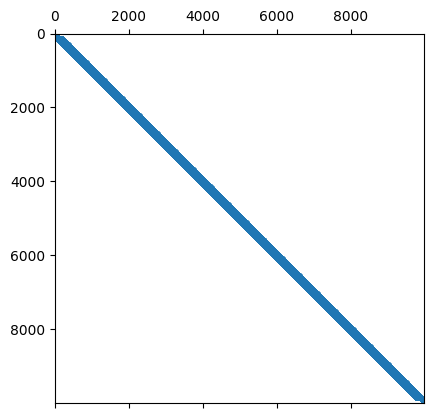

<ipython-input-21-2ebbdb197289>:15: SparseEfficiencyWarning: splu converted its input to CSC format
  lu = splu(A)


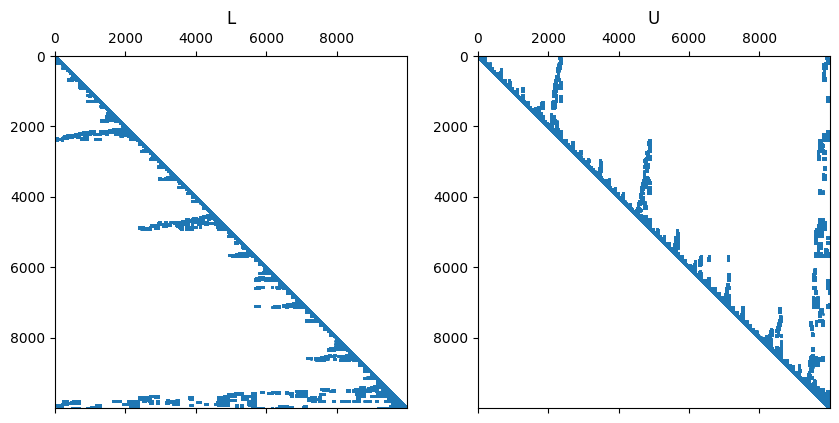

In [21]:
# prompt: Find the LU factors of A, and make spy plots of both side by side

import matplotlib.pyplot as plt
from scipy.sparse.linalg import splu,  spilu, gmres

N = 100 #Mesh size
A, f = discretise_poisson(N, 1)

import matplotlib.pyplot as plt

plt.spy(A, markersize=1)
plt.show()


lu = splu(A)
L = lu.L
U = lu.U

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.spy(L, markersize=1)
ax1.set_title('L')
ax2.spy(U, markersize=1)
ax2.set_title('U')
plt.show()


Perform sparse ilu and apply to the system.

**NOTE** The precoditioner is passed as an operator. Rather than passing $P^{-1}$ we are passing a function that solve $P x = y$. This way we avoid storing a dense matrix!

<ipython-input-13-c4528330daae>:3: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(A, fill_factor=20, drop_rule='dynamic')


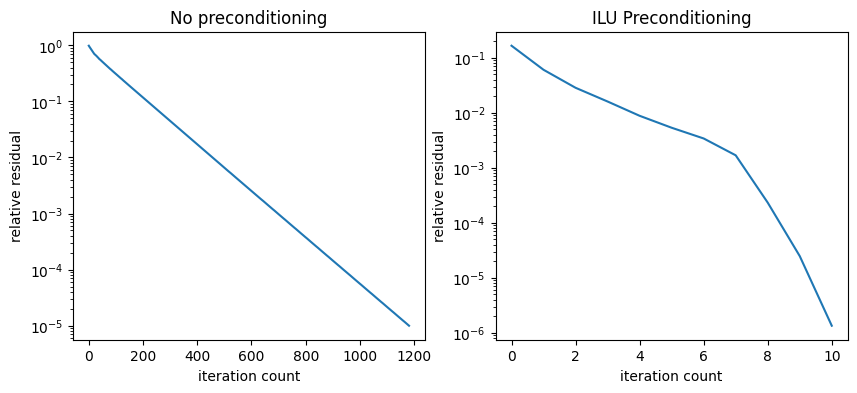

In [13]:
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spilu, LinearOperator
ilu = spilu(A, fill_factor=20, drop_rule='dynamic')

M = LinearOperator(matvec=ilu.solve, shape=(N**2, N**2), dtype=np.float64)

residuals1 = []
callback1 = lambda res: residuals1.append(res)
x, _ = gmres(A, f, callback=callback1, callback_type='pr_norm')


residuals2 = []
callback2 = lambda res: residuals2.append(res)
x, _ = gmres(A, f, M=M, callback=callback2, callback_type='pr_norm')

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.semilogy(residuals1)
ax1.set_title('No preconditioning')
ax1.set_xlabel('iteration count')
ax1.set_ylabel('relative residual')

ax2 = fig.add_subplot(122)
ax2.semilogy(residuals2)
ax2.set_title('ILU Preconditioning')
ax2.set_xlabel('iteration count')
ax2.set_ylabel('relative residual');

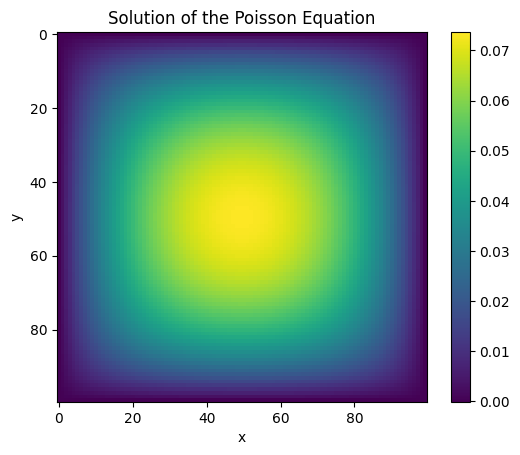

In [17]:
import matplotlib.pyplot as plt

# Assuming x_cond contains the solution obtained with preconditioning
solution = x.reshape(N, N)

plt.imshow(solution, cmap='viridis')
plt.colorbar()
plt.title('Solution of the Poisson Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


##Sparse Approximate Inverse

Sparse approximate inverse is another tool that attempts to find $P^{-1}$ so as to minimize the Frobenius norm of

$||I-AP^{-1}||$

It generates successive iterations of the preconditioner with increasing density.

In [7]:
def spai(A, m):
    """Perform m step of the SPAI iteration."""
    from scipy.sparse import identity
    from scipy.sparse import diags
    from scipy.sparse.linalg import onenormest

    n = A.shape[0]

    ident = identity(n, format='csr')
    alpha = 2 / onenormest(A @ A.T)
    M = alpha * A

    for index in range(m):
        C = A @ M
        G = ident - C
        AG = A @ G
        trace = (G.T @ AG).diagonal().sum()
        alpha = trace / np.linalg.norm(AG.data)**2
        M = M + alpha * G

    return M

Note the demonstrative example is for a different matrix.

In [8]:
import numpy as np
from scipy.sparse import diags

n = 1000

data = [2.001 * np.ones(n),
        -1. * np.ones(n - 1),
        -1. * np.ones(n - 1)]

offsets = [0, 1, -1]

A = diags(data, offsets=offsets, shape=(n, n), format='csr')

M = spai(A, 50)

print('Unconditioned condition number :', np.linalg.cond(A.todense()))
print('Preconditioned condition number :', np.linalg.cond(A.todense() @ M.todense()))

Unconditioned condition number : 3961.9652414685806
Preconditioned condition number : 40.18659718436124


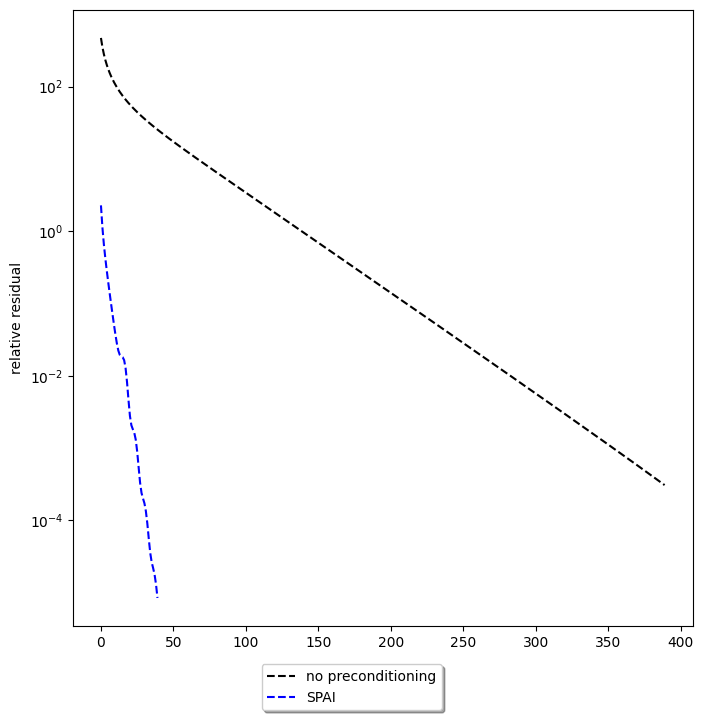

In [9]:
from scipy.sparse.linalg import cg
n = A.shape[0]
b = np.ones(n)


residuals = []
callback = lambda x: residuals.append(np.linalg.norm(A @ x - b))
x, _ = cg(A, b, callback=callback)

residuals_preconditioned = []
callback = lambda x: residuals_preconditioned.append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))
x, _ = cg(A, b, M=M, callback=callback)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(residuals, 'k--')
ax.semilogy(residuals_preconditioned, 'b--')
ax.set_ylabel('relative residual')
fig.legend(['no preconditioning', 'SPAI'], loc='lower center', fancybox=True, shadow=True)

# Preconditioners in High Performance Computing

High Performance Computing (HPC) describes systems that have a number of distributed nodes (thousands to millions of cores) connected by a high speed network. Each node has its own memory bank and possibly multiple cores which share that memory.

Effective usage of HPC requires a balance between distributed computing and the expense of inter-node communication.

- Parallelized direct solver methods do exists (most modern implementations are) but they scale poorly with the number of nodes.

- Iterative solvers parallelize better but require preconditioning for effective convergence. Since the preconditioner doesn't have to be a perfect inverse, there are strategies to distribute preconditioner computation with limited inter-node communication, which is then iterated to find the actual solution.

Let us now focus on solutions of differential equations over a given spatial domain, which is the most common area where these techniques are needed and encountered.

Note - the following are geometric methods, which implies passing of information of the geometry to the solver.

##Domain decomposition

Domain decomposition methods are the most intuitive approach since they literally partition the full domain (geometry) into smaller chunks. Each chunk is assigned to a node (or subgroup) and solved locally.

For example, a finite element representation of a plane wing, with colours denoting different *chunks*:

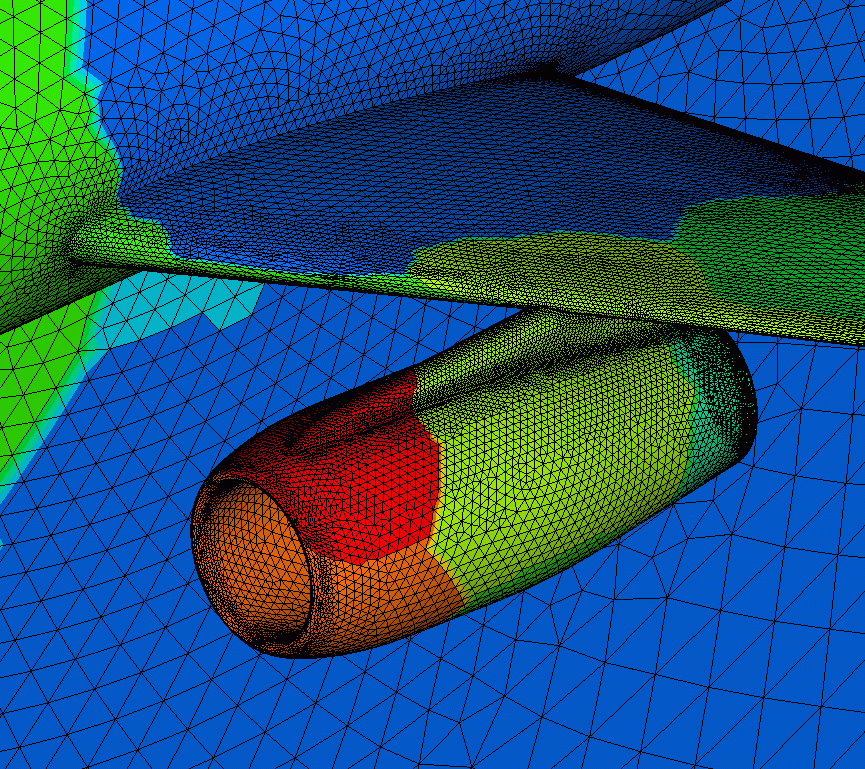

A common approach is the *Addative Schwartz method* which defines *levels of overlap* between adjacent subdomains. The overlap enables the recombination of subdomains by passing information between subdomains.

The nice thing about this is that we can do something like a direct solve on the subdomains which is great for black-box robustness! Since direct solvers scale $~O(n^3)$, this can be very effective although the cost of the global iterative scheme and the internode communication must be considered.

These methods suffer with physics that propogates quickly throughout the domain. E.g.: Elasticity which is quasitstatic - a small displacement on one side must cascade through all the chunks.

## Multigrid methods

Multigrid methods are a modern and tremendously powerful approach that can even achieve $O(n)$ scaling! The idea is to solve the differential equations on a *hierarchy of discretizations*.

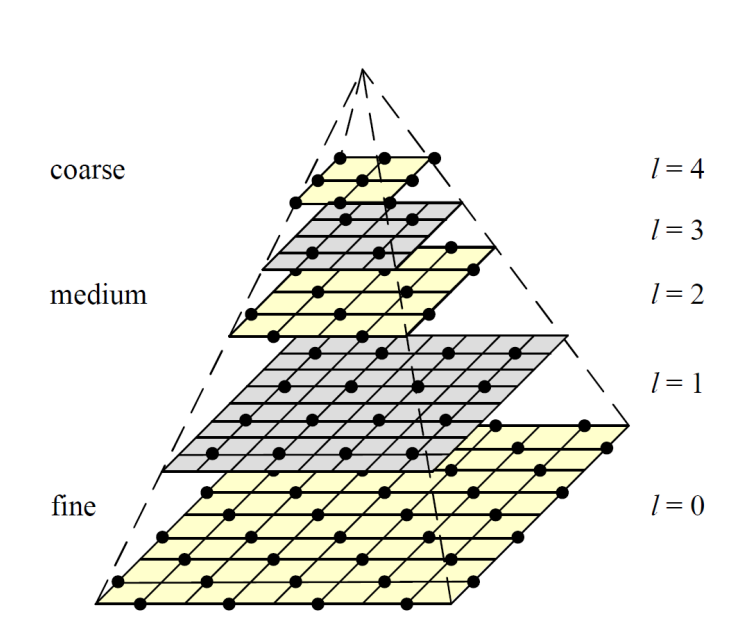

The fine domain is the resolution that you actually want, but the course domain can be small enough to treat with a direct solver (for robustness). The equations are treated to a few iterations (Commmonly SOR) on each lower level before being passed along.

The method naturally parallelizes; fine domains can be domain decomposed without overlap, because the communication is handled by the level above it.

The full mathematical analysis actually shows this method is best considered in terms of Fourier space as each level reduces certain wavelengths of the residual. Elliptic problems (e.g.: elasticity) are especially well treated since information can be passed throughout the domain on the coarse level.

- Geometric multigrid methods need to *know* about the geometry, not just the matrix.
- Algebraic multigrid methods can work completely on the matrix itself.

#Multiphysics

Typically, a certain types of physics (e.g.: parabolic / diffusive equations like heat and mass transport) will respond well to some, and other physics (e.g.elliptic / quasi-static equations like elasticity) will respond better to others. The question then is *how to combine them for a multiphysics equation?*

Generally, each type of physics will have an associated field and vector of unknowns. E.g.: the temperature and concentration fields represented by $x_T$ and $x_c$ respectively. Linear system then adopts a block structure,

$\begin{bmatrix} A_{TT} & A_{Tc} \\ A_{cT} & A_{cc} \end{bmatrix} \begin{bmatrix} x_T \\ x_c \end{bmatrix} = \begin{bmatrix} b_T \\ b_c \end{bmatrix}$

where the diagonal of the $A$ matrix reflect the type of physics (heat / mass transport) and the cross-terms reflect couping (temperature dependent diffusivity / concentration dependent conductivity). These are sometimes called *operator split* methods, *physics-based preconditioners*, or *segregated solvers*.


Typically we have some ideas how to solve the diagonals, but how do we effectively precondition the block $A$ matrix? One option is using a *block Jacobi* method:

\begin{align}
P &= \begin{bmatrix} A_{TT} & 0 \\ 0 & A_{cc} \end{bmatrix} \\
P^{-1} &= \begin{bmatrix} A^{-1}_{TT} & 0 \\ 0 & A^{-1}_{cc} \end{bmatrix}
\end{align}

For a $2x2$ block system, we may use the *block Schur complement* method:

$$
\begin{bmatrix}
A & B \\
C & D
\end{bmatrix}^{-1} =
\begin{bmatrix}
A^{-1} + A^{-1}B(D - CA^{-1}B)^{-1}CA^{-1} & -A^{-1}B(D - CA^{-1}B)^{-1} \\
-(D - CA^{-1}B)^{-1}CA^{-1} & (D - CA^{-1}B)^{-1}
\end{bmatrix}
$$
but this has a problematic $A^{-1}$ buried inside.

#Dr. Mike's tips
- Parallelized LU is still the go-to for most problems and should be your first approach.
- GMRES iteration is your next tool, but it needs preconditioning for effective use.
- If you are studying a well-known model, you can generally find good preconditioners in the literature. Use them!
- If not, most PDE solvers will have the ability to test different preconditioners and combine them hierarchically (COMSOL Multiphysics, PETSc*, etc).
- Addative Schwartz with LU on the subdomains is the most robust preconditioner I've found (aim for about n=10,000 per node).
- Geometric multigrid is finiky, but if you can get it working it is remarkable (Use it for elasticity!).


*Portable, Extensible Toolkit for Scientific Computation https://petsc.org/release/

